# Análisis Temporal y Temático del BOE 2024 (v2)

Modificaciones:
- **SARIMAX explicado y justificado** (selección de órdenes, diagnóstico de residuos, comparación con baseline).
- **Variables exógenas razonables**: *proxy* de vacaciones (agosto) y festivos nacionales (2024).
- **Tópicos**: técnicas adicionales (dependencia entre tópicos, contraste estadístico agosto vs resto, PCA, causalidad de Granger, drift por divergencias).

> Nota: el dataset está agregado por **semana ISO** (52 observaciones). Eso limita el modelado estacional anual (52) porque solo hay **un ciclo** completo.

## 1. Importación y carga de datos

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.special import rel_entr
from scipy.stats import chi2_contingency, spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram
from numpy.linalg import svd
import itertools
import warnings
warnings.filterwarnings("ignore")

# --- Paths (robusto: carpeta actual o /mnt/data) ---
DATA_FILE = "dataset_boe_temporal_sin_sentimiento_por_semana_con_topico.csv"
if not os.path.exists(DATA_FILE) and os.path.exists("/mnt/data/" + DATA_FILE):
    DATA_FILE = "/mnt/data/" + DATA_FILE

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

df = pd.read_csv(DATA_FILE)
df.head()

,semana,seccion_nombre_I. Disposiciones generales,"seccion_nombre_II. Autoridades y personal. - A. Nombramientos, situaciones e incidencias",seccion_nombre_II. Autoridades y personal. - B. Oposiciones y concursos,seccion_nombre_III. Otras disposiciones,seccion_nombre_T.C. Sección del Tribunal Constitucional,departamento_nombre_ADMINISTRACIÓN LOCAL,departamento_nombre_AGENCIA ESPAÑOLA DE PROTECCIÓN DE DATOS,departamento_nombre_BANCO DE ESPAÑA,departamento_nombre_COMISIÓN NACIONAL DE LOS MERCADOS Y LA COMPETENCIA,...,topico_Cultura y Patrimonio,"topico_Economia, Hacienda y Finanzas",topico_Educacion y Universidades,topico_Empleo Publico y Oposiciones,topico_Energia y Medio Ambiente,"topico_Justicia, Seguridad y Migraciones",topico_Relaciones Exteriores y Cooperacion Internacional,topico_Sanidad y Politica Social,"topico_Transporte, Infraestructuras y Vivienda",publicaciones_semana
0,1,22,55,250,291,0,147,0,10,6,...,2,11,14,51,25,1,8,1,4,618
1,2,20,84,89,130,0,73,0,7,0,...,3,15,1,23,9,2,4,4,5,323
2,3,21,79,141,117,20,95,0,8,1,...,0,14,4,19,5,15,16,4,4,378
3,4,22,72,187,195,0,130,1,6,1,...,2,10,24,47,10,2,12,0,4,476
4,5,27,87,216,194,0,148,0,10,3,...,6,15,29,34,8,5,8,2,4,524


## 2. Conversión temporal y serie semanal

In [19]:
# Convertimos semana ISO (semana 1..52) a fecha de lunes (week_start)
df['week_start'] = pd.to_datetime(
    df['semana'].astype(int).astype(str).radd('2024-W') + '-1',
    format='%G-W%V-%u'
)
df = df.sort_values('week_start').reset_index(drop=True)

# Serie principal
ts = df.set_index('week_start')['publicaciones_semana'].asfreq('W-MON')

# Chequeo rápido
print("N semanas:", len(ts), " | Rango:", ts.index.min().date(), "->", ts.index.max().date())
ts.head()

N semanas: 52  | Rango: 2024-01-01 -> 2024-12-23


week_start
2024-01-01    618
2024-01-08    323
2024-01-15    378
2024-01-22    476
2024-01-29    524
Freq: W-MON, Name: publicaciones_semana, dtype: int64

## 3. Exploración: patrón mensual y posible efecto agosto (vacaciones)

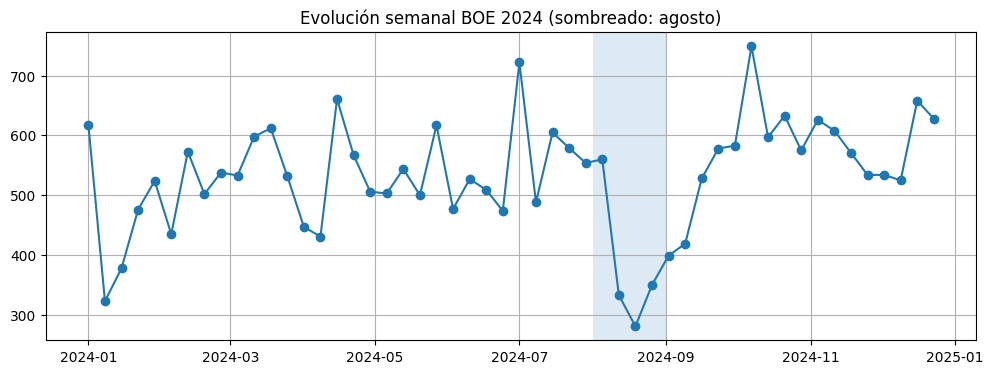

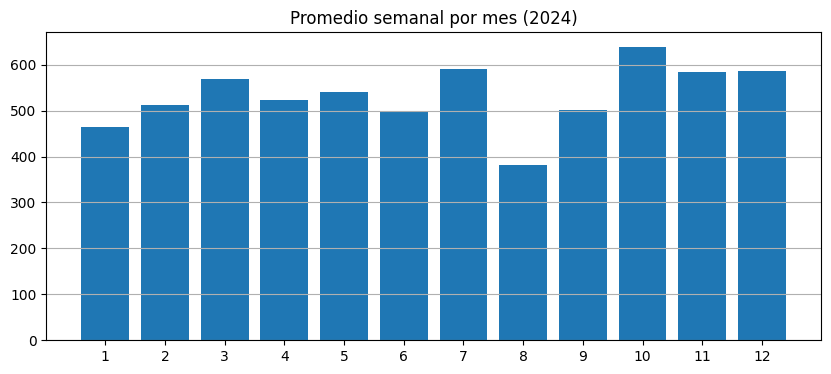

Media anual: 531.1923076923077
Media agosto: 381.0


In [20]:
# Promedio por mes (vista rápida)
monthly_mean = ts.groupby(ts.index.month).mean()

plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, marker='o')
plt.axvspan(pd.Timestamp('2024-08-01'), pd.Timestamp('2024-09-01'), alpha=0.15)  # agosto
plt.grid(True)
plt.title("Evolución semanal BOE 2024 (sombreado: agosto)")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(monthly_mean.index, monthly_mean.values)
plt.grid(True, axis='y')
plt.title("Promedio semanal por mes (2024)")
plt.xticks(range(1,13))
plt.show()

print("Media anual:", ts.mean())
print("Media agosto:", ts[ts.index.month==8].mean())

## 4. Estacionariedad y autocorrelación

- Usamos **ADF** para evaluar si hace falta diferenciar (d).
- Usamos **ACF/PACF** como guía para órdenes AR/MA iniciales.

ADF stat=-4.492 | p-value=0.0002
=> Si p<0.05, tratamos la serie como estacionaria (d=0).


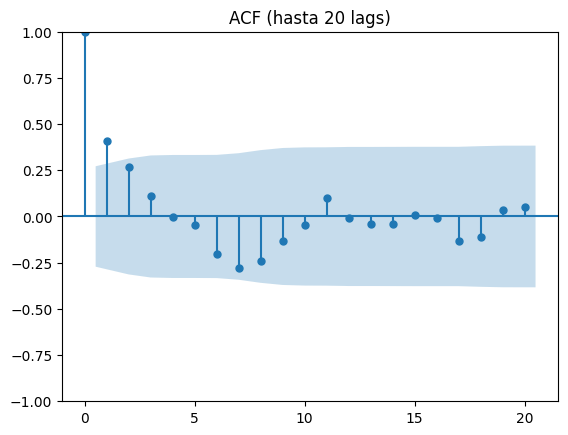

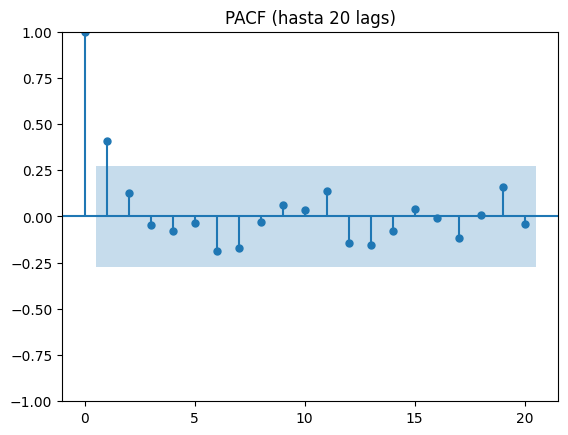

In [21]:
# ADF (Augmented Dickey-Fuller)
adf_stat, adf_p, *_ = adfuller(ts.dropna())
print(f"ADF stat={adf_stat:.3f} | p-value={adf_p:.4f}")
print("=> Si p<0.05, tratamos la serie como estacionaria (d=0).")

# ACF/PACF
plot_acf(ts, lags=20)
plt.title("ACF (hasta 20 lags)")
plt.show()

plot_pacf(ts, lags=20, method='ywm')
plt.title("PACF (hasta 20 lags)")
plt.show()

## 5. Variables exógenas (exog) justificadas

Variables exógenas razonables (ej. vacaciones en España).

**Proxy elegido:**
- `is_august`: 1 si la semana cae en agosto. Captura el patrón observado (bajada fuerte en agosto).
- `holiday_count`: nº de festivos nacionales que caen en días laborables (L-V) dentro de la semana.

Fechas de festivos nacionales 2024 (referencias externas):
- Listados de festivos: TimeAndDate / OfficeHolidays / calendario oficial Madrid (PDF).  
(Úsalos en la memoria si te piden fuente.)

In [22]:
from datetime import date

# Festivos nacionales (selección mínima común). Nota: hay festivos regionales/locales; aquí usamos un baseline nacional.
# Fuentes típicas de consulta: timeanddate.com / officeholidays.com / calendarios oficiales autonómicos.
holidays_2024 = {
    date(2024,1,1),   # Año Nuevo
    date(2024,1,6),   # Epifanía
    date(2024,3,29),  # Viernes Santo
    date(2024,5,1),   # Día del Trabajo
    date(2024,8,15),  # Asunción
    date(2024,10,12), # Fiesta Nacional
    date(2024,11,1),  # Todos los Santos
    date(2024,12,6),  # Constitución
    date(2024,12,25), # Navidad
}

def holiday_count_in_week(week_start):
    days = pd.date_range(week_start, week_start + pd.Timedelta(days=6), freq='D')
    # contamos solo festivos que caen en día laborable (L-V), porque afectan más a la actividad administrativa
    return sum((d.weekday() < 5) and (d.date() in holidays_2024) for d in days)

exog = pd.DataFrame(index=ts.index)
exog['is_august'] = (exog.index.month == 8).astype(int)
exog['holiday_count'] = [holiday_count_in_week(ws) for ws in exog.index]

# ejemplo
exog.head()

,is_august,holiday_count
week_start,,
2024-01-01,0,1
2024-01-08,0,0
2024-01-15,0,0
2024-01-22,0,0
2024-01-29,0,0


## 6. Split Train/Test (y baseline Holt-Winters)

Exog usadas: ['is_august', 'holiday_count']
Train: 2024-01-01 -> 2024-10-07 | n= 41
Test : 2024-10-14 -> 2024-12-23 | n= 11
Holt-Winters -> MAE=86.04 | RMSE=97.73


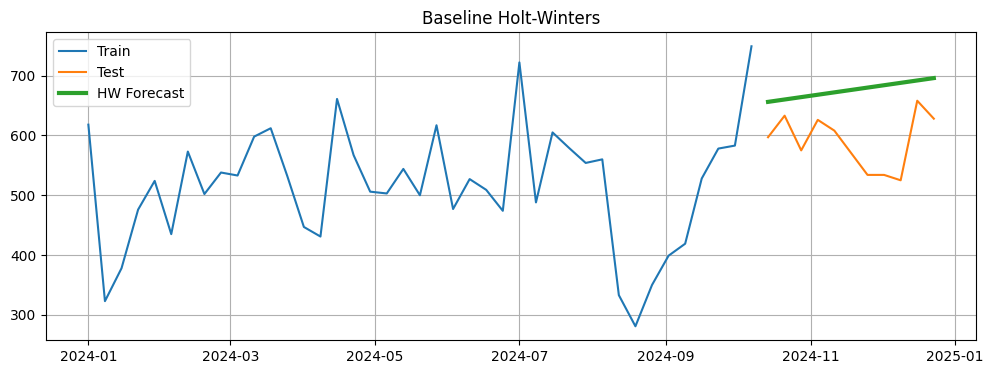

In [23]:
n = len(ts)
train_size = int(n * 0.8)
ts_train = ts.iloc[:train_size]
ts_test  = ts.iloc[train_size:]

# Importante: eliminar columnas exógenas constantes en train (evita problemas de estimación)
exog_train = exog.iloc[:train_size]
exog_test  = exog.iloc[train_size:]
valid_exog_cols = [c for c in exog.columns if exog_train[c].nunique() > 1]
exog_train = exog_train[valid_exog_cols]
exog_test  = exog_test[valid_exog_cols]

print("Exog usadas:", valid_exog_cols)
print("Train:", ts_train.index.min().date(), "->", ts_train.index.max().date(), "| n=", len(ts_train))
print("Test :", ts_test.index.min().date(), "->", ts_test.index.max().date(), "| n=", len(ts_test))

# Holt-Winters baseline (tendencia aditiva, sin estacionalidad: solo 52 puntos)
model_hw = ExponentialSmoothing(ts_train, trend="add", seasonal=None)
fit_hw = model_hw.fit()
pred_hw = fit_hw.forecast(len(ts_test))

mae_hw = mean_absolute_error(ts_test, pred_hw)
rmse_hw = np.sqrt(mean_squared_error(ts_test, pred_hw))

print(f"Holt-Winters -> MAE={mae_hw:.2f} | RMSE={rmse_hw:.2f}")

plt.figure(figsize=(12,4))
plt.plot(ts_train.index, ts_train, label="Train")
plt.plot(ts_test.index, ts_test, label="Test")
plt.plot(ts_test.index, pred_hw, linewidth=3, label="HW Forecast")
plt.grid(True)
plt.title("Baseline Holt-Winters")
plt.legend()
plt.show()

## 7. SARIMAX (análisis completo)

Lo que se añade
1) **Selección de modelo** con un grid pequeño y razonado  
2) **Comparación** con baseline (HW)  
3) **Diagnóstico** de residuos (Ljung-Box, ACF de residuos)

Justificación de búsqueda:
- Serie semanal corta (52): se restringe el grid a órdenes pequeños para evitar sobreajuste.
- Se prueba estacionalidad **s=4** (aprox. ciclo mensual en agregación semanal), porque con 52 puntos hay 13 ciclos (más estable que s=13 con solo 4 ciclos).

In [24]:
def eval_sarimax(order, seasonal_order=None):
    model = SARIMAX(
        ts_train,
        exog=exog_train if exog_train.shape[1] else None,
        order=order,
        seasonal_order=seasonal_order if seasonal_order else (0,0,0,0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False, maxiter=200)
    pred = res.get_forecast(steps=len(ts_test), exog=(exog_test if exog_test.shape[1] else None)).predicted_mean
    rmse = np.sqrt(mean_squared_error(ts_test, pred))
    mae = mean_absolute_error(ts_test, pred)
    return {
        "order": order,
        "seasonal_order": seasonal_order if seasonal_order else (0,0,0,0),
        "aic": res.aic,
        "rmse": rmse,
        "mae": mae,
        "res": res,
        "pred": pred
    }

# Grid pequeño (razonado)
orders = [(p,0,q) for p in range(0,4) for q in range(0,4)]
seasonals = [None, (1,0,1,4)]  # sin estacionalidad vs s=4

results = []
for o in orders:
    for so in seasonals:
        try:
            results.append(eval_sarimax(o, so))
        except Exception:
            pass

# Top modelos por RMSE
top = sorted(results, key=lambda x: x["rmse"])[:8]
pd.DataFrame([{
    "order": t["order"],
    "seasonal_order": t["seasonal_order"],
    "AIC": round(t["aic"],2),
    "RMSE": round(t["rmse"],2),
    "MAE": round(t["mae"],2),
} for t in top])

,order,seasonal_order,AIC,RMSE,MAE
0,"(1, 0, 2)","(0, 0, 0, 0)",459.29,46.58,42.38
1,"(0, 0, 0)","(1, 0, 1, 4)",443.59,49.05,43.94
2,"(0, 0, 1)","(1, 0, 1, 4)",431.53,49.93,44.27
3,"(1, 0, 3)","(0, 0, 0, 0)",447.70,52.25,45.01
4,"(3, 0, 3)","(0, 0, 0, 0)",463.48,55.62,44.02
5,"(3, 0, 0)","(1, 0, 1, 4)",416.21,59.83,48.69
6,"(2, 0, 3)","(1, 0, 1, 4)",408.76,65.30,53.30
7,"(0, 0, 3)","(1, 0, 1, 4)",415.26,70.70,57.39


### 7.1 Modelo elegido (mejor RMSE) + visualización

Mejor SARIMAX encontrado:
order = (1, 0, 2)  seasonal_order = (0, 0, 0, 0)
MAE=42.38 | RMSE=46.58 | AIC=459.29


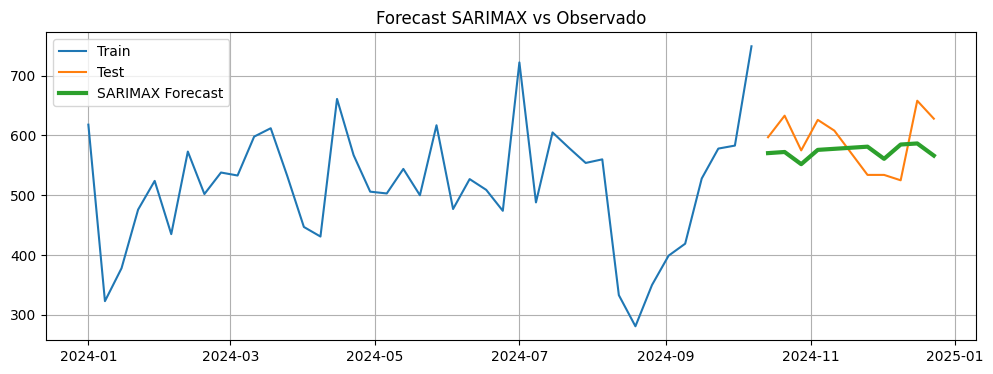

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     publicaciones_semana   No. Observations:                   41
Model:                 SARIMAX(1, 0, 2)   Log Likelihood                -223.645
Date:                  Fri, 19 Dec 2025   AIC                            459.291
Time:                          02:46:06   BIC                            469.116
Sample:                      01-01-2024   HQIC                           462.787
                           - 10-07-2024                                         
Covariance Type:                    opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
is_august      -169.3665     36.635     -4.623      0.000    -241.170     -97.563
holiday_count   -22.1195    137.317     -0.161      0.872    -291.256     247.017
ar.L1             1.0031      0.002    408.549      0.000       0.998       1.008
ma.L1         -1346.4167      0.018  -7.41e+04      0.000   -1346.452   -1346.381
ma.L2          1345.5314      0.011   1.22e+05      0.000    1345.510    1345.553
sigma2            0.0038      0.001      3.855      0.000       0.002       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.52   Prob(JB):                         0.84
Heteroskedasticity (H):               1.69   Skew:                             0.18
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.29e+23. Standard errors may be unstable.
"""

In [25]:
best = sorted(results, key=lambda x: x["rmse"])[0]
best_order = best["order"]
best_seasonal = best["seasonal_order"]
fit_sx = best["res"]
pred_sx = best["pred"]

print("Mejor SARIMAX encontrado:")
print("order =", best_order, " seasonal_order =", best_seasonal)
print(f"MAE={best['mae']:.2f} | RMSE={best['rmse']:.2f} | AIC={best['aic']:.2f}")

plt.figure(figsize=(12,4))
plt.plot(ts_train.index, ts_train, label="Train")
plt.plot(ts_test.index, ts_test, label="Test")
plt.plot(ts_test.index, pred_sx, linewidth=3, label="SARIMAX Forecast")
plt.grid(True)
plt.title("Forecast SARIMAX vs Observado")
plt.legend()
plt.show()

# Resumen (para que el profesor vea SARIMAX en claro)
fit_sx.summary()

### 7.2 Interpretación rápida de exog (vacaciones explican algo?)

In [26]:
if exog_train.shape[1]:
    params = fit_sx.params.filter(like='is_august', axis=0) if hasattr(fit_sx.params, 'filter') else fit_sx.params
    print("Coeficientes (params):")
    print(fit_sx.params)
    print("\nP-values:")
    print(fit_sx.pvalues)
else:
    print("No hay variables exógenas válidas (todas constantes en train).")

Coeficientes (params):
is_august        -169.366537
holiday_count     -22.119485
ar.L1               1.003083
ma.L1           -1346.416694
ma.L2            1345.531386
sigma2              0.003799
dtype: float64

P-values:
is_august        0.000004
holiday_count    0.872028
ar.L1            0.000000
ma.L1            0.000000
ma.L2            0.000000
sigma2           0.000116
dtype: float64


### 7.3 Diagnóstico de residuos (ACF + Ljung-Box)

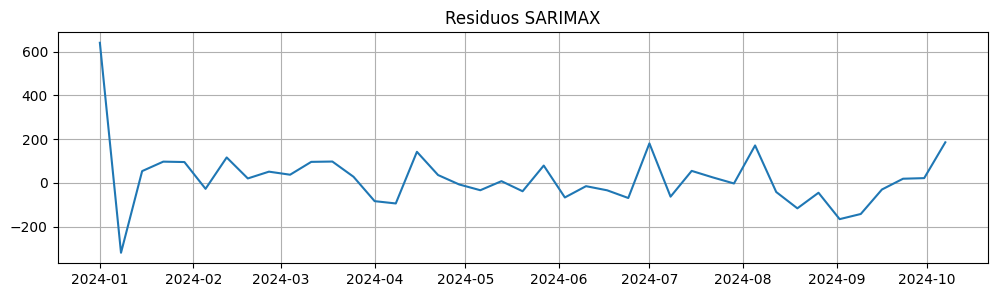

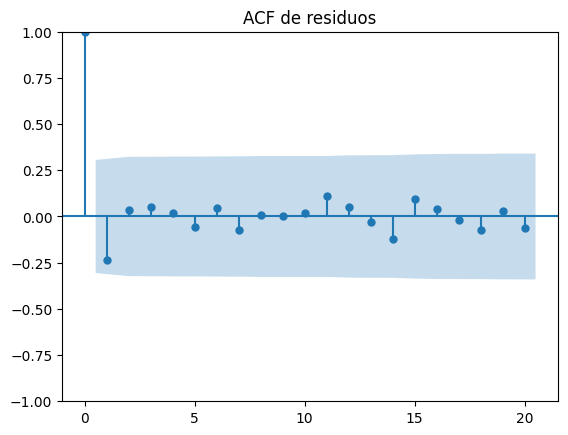

,lb_stat,lb_pvalue
5,2.842930,0.724186
10,3.259164,0.974650
15,5.738557,0.983813


In [27]:
resid = fit_sx.resid

plt.figure(figsize=(12,3))
plt.plot(resid)
plt.grid(True)
plt.title("Residuos SARIMAX")
plt.show()

plot_acf(resid.dropna(), lags=20)
plt.title("ACF de residuos")
plt.show()

lb = acorr_ljungbox(resid.dropna(), lags=[5,10,15], return_df=True)
lb

## 8. Detección de anomalías (mejorada)

En vez de aplicar IsolationForest sobre la serie cruda, aquí marcamos anomalías como semanas con **residuos estandarizados** grandes.  
Esto es más interpretable: *“esta semana se desvía mucho de lo esperado por el modelo”*.

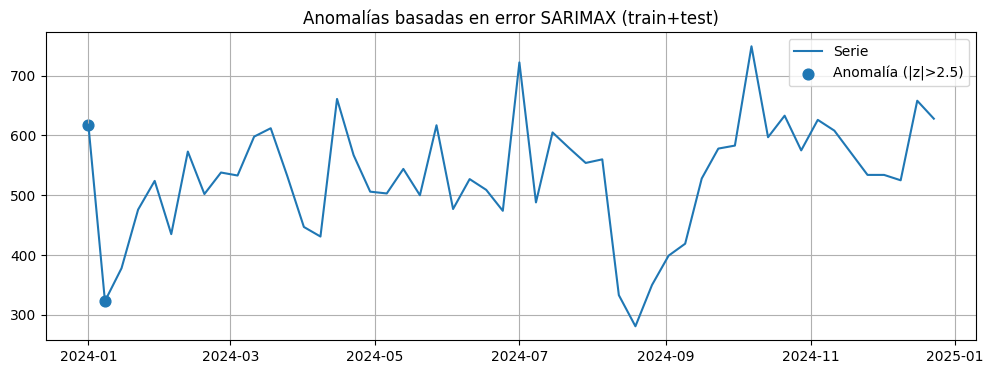

,publicaciones_semana,error,error_z
week_start,,,
2024-01-08,323,-319.092789,-2.733336
2024-01-01,618,640.119485,4.994640


In [28]:
# --- 8. Anomalías (train + test) sin desajuste de longitudes ---

# 1) Residuos in-sample del train (alineados por índice)
resid_train = pd.Series(fit_sx.resid, index=ts_train.index)

# 2) Error out-of-sample del test (observado - predicho)
err_test = (ts_test - pred_sx)
err_test = pd.Series(err_test.values, index=ts_test.index)

# 3) Unimos errores (52 semanas)
err_all = pd.concat([resid_train, err_test]).sort_index()

# 4) Estandarizamos y marcamos anomalías
err_z = (err_all - err_all.mean()) / err_all.std(ddof=0)
anom_mask = err_z.abs() > 2.5

# 5) Plot: usamos el índice de err_all (mismo tamaño que ts)
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts.values, label="Serie")
plt.scatter(err_all.index[anom_mask],
            ts.loc[err_all.index[anom_mask]].values,
            s=60, marker="o", label="Anomalía (|z|>2.5)")
plt.grid(True)
plt.title("Anomalías basadas en error SARIMAX (train+test)")
plt.legend()
plt.show()

# Tabla de anomalías
df_anom = pd.DataFrame({
    "publicaciones_semana": ts,
    "error": err_all,
    "error_z": err_z
})
df_anom[anom_mask].sort_values("error_z")


## 9. Análisis temático: proporciones por tópico

In [29]:
topic_cols = [c for c in df.columns if c.startswith("topico_")]
topic_mat = df[topic_cols].to_numpy(dtype=float)

# Proporciones por semana (control de división por cero)
row_sum = topic_mat.sum(axis=1, keepdims=True)
row_sum[row_sum == 0] = 1.0
P = topic_mat / row_sum

df_prop = pd.DataFrame(P, columns=topic_cols)
df_prop['week_start'] = df['week_start']
df_prop = df_prop.set_index('week_start').asfreq('W-MON')

df_prop.head()

,topico_Administracion y Legislacion Civil,"topico_Agricultura, Pesca y Alimentacion",topico_Ciencia e Investigacion,topico_Cultura y Patrimonio,"topico_Economia, Hacienda y Finanzas",topico_Educacion y Universidades,topico_Empleo Publico y Oposiciones,topico_Energia y Medio Ambiente,"topico_Justicia, Seguridad y Migraciones",topico_Relaciones Exteriores y Cooperacion Internacional,topico_Sanidad y Politica Social,"topico_Transporte, Infraestructuras y Vivienda"
week_start,,,,,,,,,,,,
2024-01-01,0.781553,0.008091,0.021036,0.003236,0.017799,0.022654,0.082524,0.040453,0.001618,0.012945,0.001618,0.006472
2024-01-08,0.783282,0.009288,0.003096,0.009288,0.046440,0.003096,0.071207,0.027864,0.006192,0.012384,0.012384,0.015480
2024-01-15,0.764550,0.010582,0.010582,0.000000,0.037037,0.010582,0.050265,0.013228,0.039683,0.042328,0.010582,0.010582
2024-01-22,0.752101,0.004202,0.010504,0.004202,0.021008,0.050420,0.098739,0.021008,0.004202,0.025210,0.000000,0.008403
2024-01-29,0.765267,0.007634,0.015267,0.011450,0.028626,0.055344,0.064885,0.015267,0.009542,0.015267,0.003817,0.007634


### 9.1 Evolución de tópicos (serie multivariante)

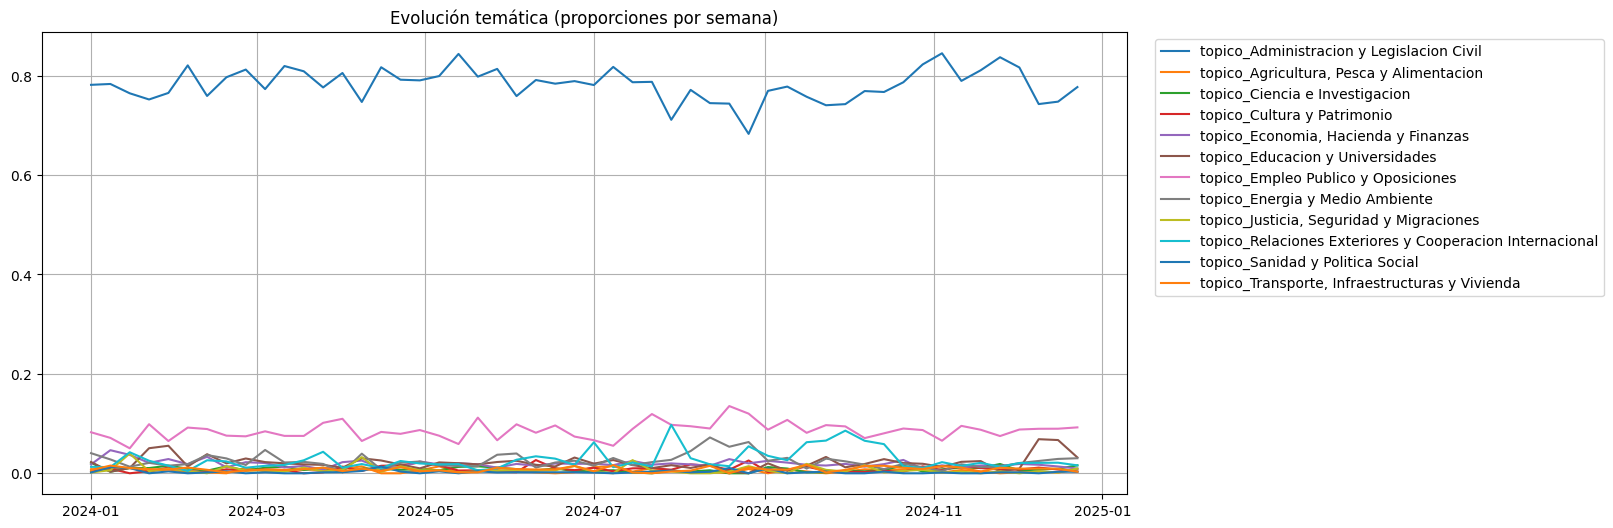

In [30]:
plt.figure(figsize=(14,6))
for c in topic_cols:
    plt.plot(df_prop.index, df_prop[c], label=c)
plt.grid(True)
plt.title("Evolución temática (proporciones por semana)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

## 10. Dependencia entre tópicos

### 10.1 Correlación de Spearman + control por FDR
- Correlación sobre proporciones semanales (no sobre counts brutos).
- Ajuste Benjamini–Hochberg para evitar falsos positivos por múltiples comparaciones.

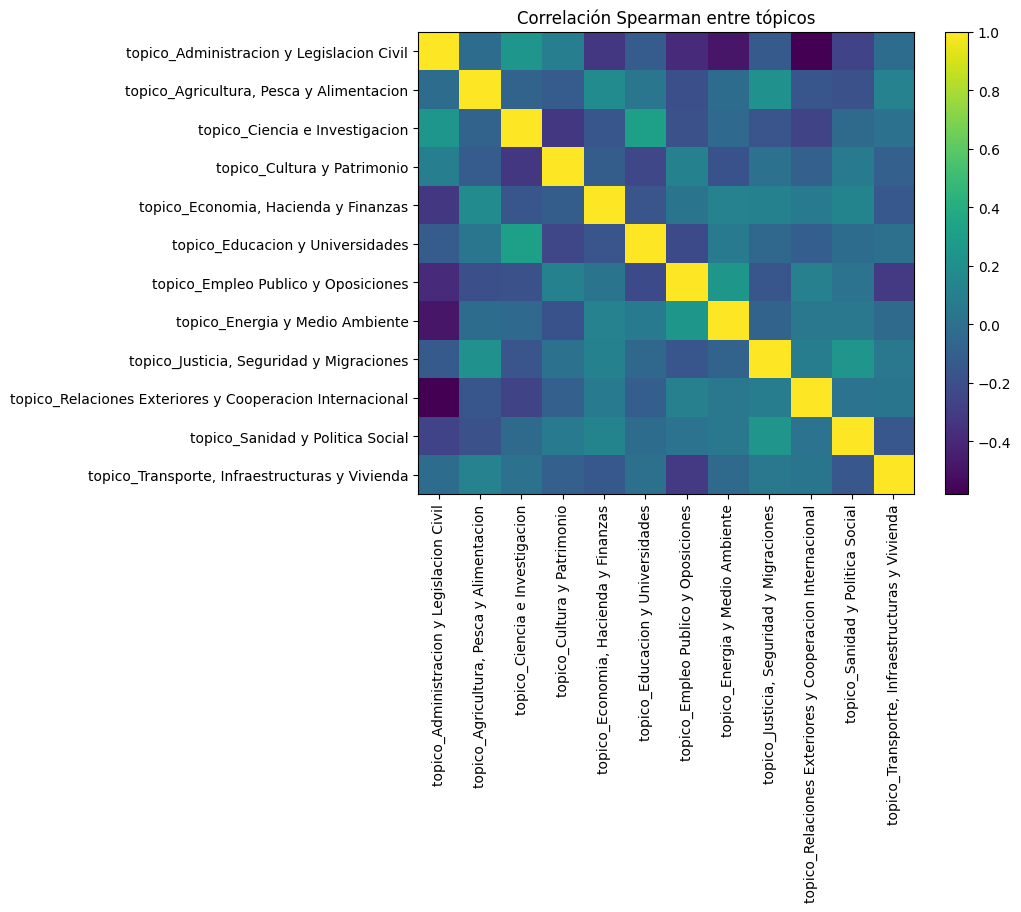

,topico_1,topico_2,rho_spearman,p_FDR
1,topico_Administracion y Legislacion Civil,topico_Relaciones Exteriores y Cooperacion Int...,-0.580125,0.000433
0,topico_Administracion y Legislacion Civil,topico_Energia y Medio Ambiente,-0.485017,0.008856


In [31]:
# Matriz de correlación (Spearman)
corr = df_prop[topic_cols].corr(method='spearman')

plt.figure(figsize=(8,6))
plt.imshow(corr.values, aspect='auto')
plt.xticks(range(len(topic_cols)), topic_cols, rotation=90)
plt.yticks(range(len(topic_cols)), topic_cols)
plt.colorbar()
plt.title("Correlación Spearman entre tópicos")
plt.show()

# p-values Spearman por pares
pvals = pd.DataFrame(np.ones((len(topic_cols), len(topic_cols))), index=topic_cols, columns=topic_cols)
for i, j in itertools.combinations(topic_cols, 2):
    r, p = spearmanr(df_prop[i], df_prop[j])
    pvals.loc[i, j] = p
    pvals.loc[j, i] = p

# Benjamini–Hochberg (FDR)
tri = pvals.where(np.triu(np.ones(pvals.shape), 1).astype(bool))
pv_list = tri.stack().values
m = len(pv_list)
order = np.argsort(pv_list)
pv_sorted = pv_list[order]
adj_sorted = pv_sorted * m / np.arange(1, m+1)
adj_sorted = np.minimum.accumulate(adj_sorted[::-1])[::-1]
adj = np.empty_like(adj_sorted)
adj[order] = adj_sorted

adj_mat = pd.DataFrame(np.ones_like(pvals), index=topic_cols, columns=topic_cols)
pairs = list(tri.stack().index)
for (i, j), a in zip(pairs, adj):
    adj_mat.loc[i, j] = a
    adj_mat.loc[j, i] = a

sig_pairs = []
for i, j in itertools.combinations(topic_cols, 2):
    if adj_mat.loc[i, j] < 0.05:
        sig_pairs.append((i, j, corr.loc[i, j], adj_mat.loc[i, j]))

pd.DataFrame(sig_pairs, columns=["topico_1","topico_2","rho_spearman","p_FDR"]).sort_values("p_FDR")

### 10.2 Dendrograma (clustering de tópicos por similitud)

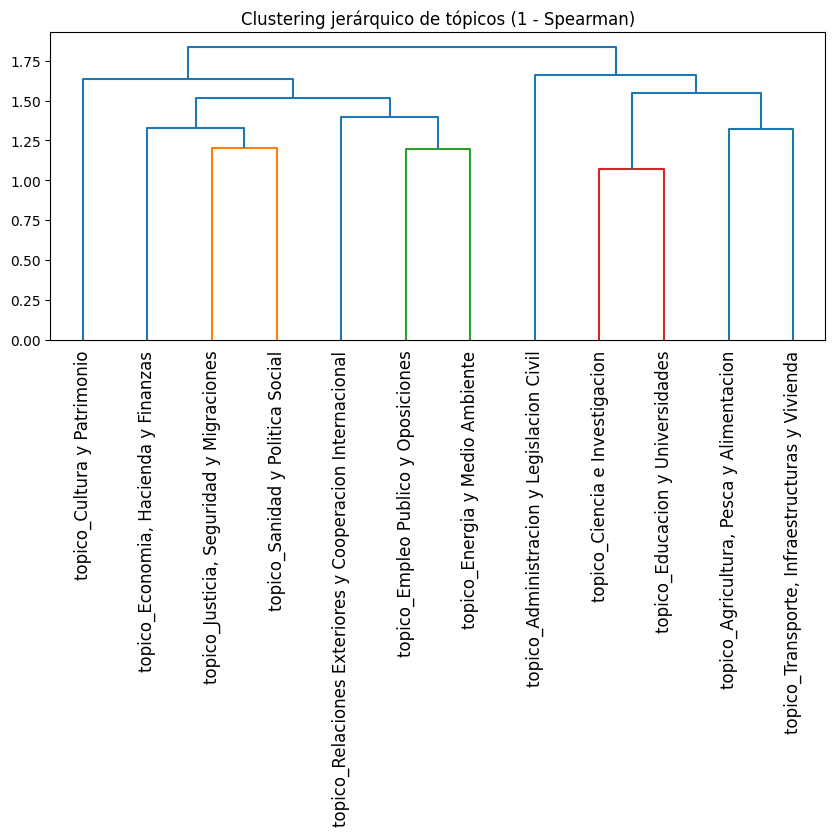

In [32]:
# Distancia = 1 - correlación (recortamos para evitar problemas numéricos)
dist = 1 - corr.clip(-1, 1)
Z = linkage(dist, method="average")

plt.figure(figsize=(10,4))
dendrogram(Z, labels=topic_cols, leaf_rotation=90)
plt.title("Clustering jerárquico de tópicos (1 - Spearman)")
plt.tight_layout()
plt.show()

## 11. Contraste Agosto vs resto (Chi-cuadrado)

Esto añade evidencia “formal” de que en agosto no solo cae el volumen, sino que **cambia el mix temático**.

In [33]:
aug_mask = df['week_start'].dt.month == 8
aug_total = df.loc[aug_mask, topic_cols].sum()
non_total = df.loc[~aug_mask, topic_cols].sum()

cont = np.vstack([aug_total.values, non_total.values])
chi2, p, dof, exp = chi2_contingency(cont)

print(f"Chi2={chi2:.2f} | dof={dof} | p-value={p:.3e}")

# residuos estandarizados (qué tópicos cambian más en agosto)
resid_std = (cont - exp) / np.sqrt(exp)
std_res = pd.Series(resid_std[0], index=topic_cols).sort_values(key=np.abs, ascending=False)

std_res.head(10)

Chi2=125.61 | dof=11 | p-value=1.342e-21


topico_Energia y Medio Ambiente                             8.387860
topico_Cultura y Patrimonio                                 3.689414
topico_Educacion y Universidades                           -3.593362
topico_Empleo Publico y Oposiciones                         2.917257
topico_Ciencia e Investigacion                             -2.408708
topico_Administracion y Legislacion Civil                  -1.922675
topico_Justicia, Seguridad y Migraciones                   -1.344124
topico_Agricultura, Pesca y Alimentacion                   -1.044804
topico_Sanidad y Politica Social                            0.677906
topico_Relaciones Exteriores y Cooperacion Internacional    0.530697
dtype: float64

## 12. PCA sobre tópicos (reducción de dimensión)

Técnica de clase típica para “resumir” patrones multivariantes:
- Componentes principales sobre proporciones.
- Interpretación: “modo” temático dominante y su evolución temporal.

Varianza explicada PC1, PC2, PC3: [0.564 0.154 0.115]


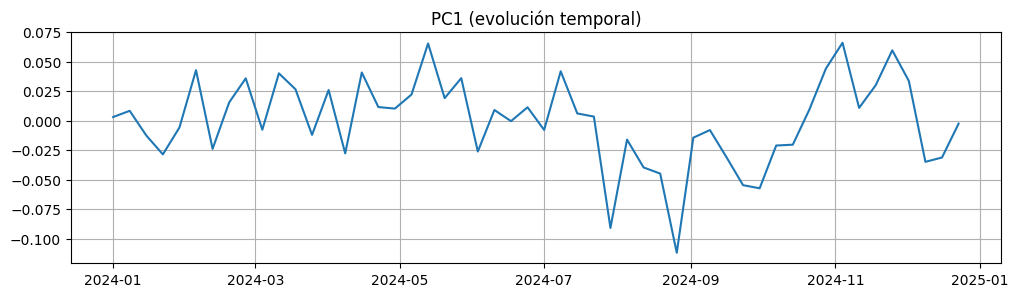

topico_Administracion y Legislacion Civil                   0.878192
topico_Relaciones Exteriores y Cooperacion Internacional   -0.369608
topico_Empleo Publico y Oposiciones                        -0.206704
topico_Energia y Medio Ambiente                            -0.205518
topico_Ciencia e Investigacion                              0.046345
topico_Educacion y Universidades                           -0.044483
topico_Justicia, Seguridad y Migraciones                   -0.036816
topico_Economia, Hacienda y Finanzas                       -0.036790
dtype: float64

In [34]:
X = df_prop[topic_cols].values
X = X - X.mean(axis=0, keepdims=True)

# PCA vía SVD
U, S, Vt = svd(X, full_matrices=False)
explained_var = (S**2) / (len(X)-1)
explained_ratio = explained_var / explained_var.sum()

print("Varianza explicada PC1, PC2, PC3:", explained_ratio[:3].round(3))

pc1 = U[:,0] * S[0]
pc2 = U[:,1] * S[1]

plt.figure(figsize=(12,3))
plt.plot(df_prop.index, pc1)
plt.grid(True)
plt.title("PC1 (evolución temporal)")
plt.show()

loadings = pd.Series(Vt[0], index=topic_cols).sort_values(key=np.abs, ascending=False)
loadings.head(8)

## 13. Dependencia temporal entre tópicos: Causalidad de Granger (exploratorio)

Esto evalúa si el pasado de un tópico aporta información para predecir otro (con *lags* pequeños).  
Es exploratorio (52 puntos). Se controla por múltiples tests con FDR.

In [35]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 2
edges = []
for cause, effect in itertools.permutations(topic_cols, 2):
    data = df_prop[[effect, cause]]  # y, x
    try:
        out = grangercausalitytests(data, maxlag=maxlag, verbose=False)
        pmin = min(out[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag+1))
        edges.append((cause, effect, pmin))
    except Exception:
        pass

# FDR
pvals = np.array([e[2] for e in edges])
m = len(pvals)
order = np.argsort(pvals)
pv_sorted = pvals[order]
adj_sorted = pv_sorted * m / np.arange(1, m+1)
adj_sorted = np.minimum.accumulate(adj_sorted[::-1])[::-1]
adj = np.empty_like(adj_sorted)
adj[order] = adj_sorted

edges_adj = [(edges[i][0], edges[i][1], edges[i][2], adj[i]) for i in range(len(edges))]
sig = [e for e in edges_adj if e[3] < 0.05]

pd.DataFrame(sig, columns=["causa","efecto","p_min","p_FDR"]).sort_values("p_FDR").head(15)

,causa,efecto,p_min,p_FDR
1,topico_Ciencia e Investigacion,topico_Relaciones Exteriores y Cooperacion Int...,0.000553,0.036470
2,"topico_Economia, Hacienda y Finanzas","topico_Justicia, Seguridad y Migraciones",0.000538,0.036470
0,topico_Ciencia e Investigacion,topico_Administracion y Legislacion Civil,0.001203,0.039688
3,topico_Energia y Medio Ambiente,topico_Sanidad y Politica Social,0.000977,0.039688


## 14. Drift temático: KL y Jensen–Shannon

- **KL semanal vs distribución anual** 
- **Jensen–Shannon entre semanas consecutivas** para detectar “saltos” temáticos.

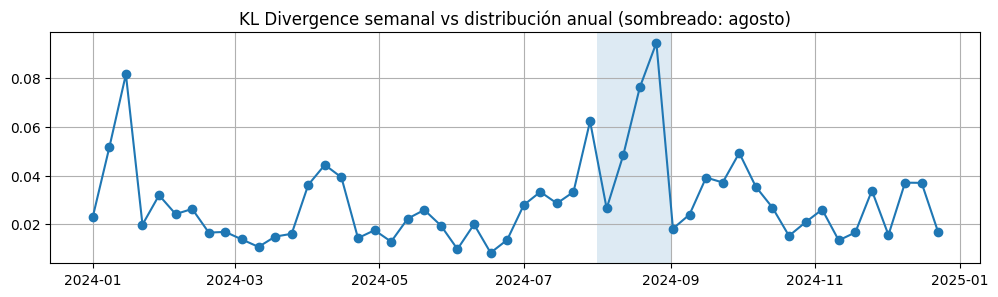

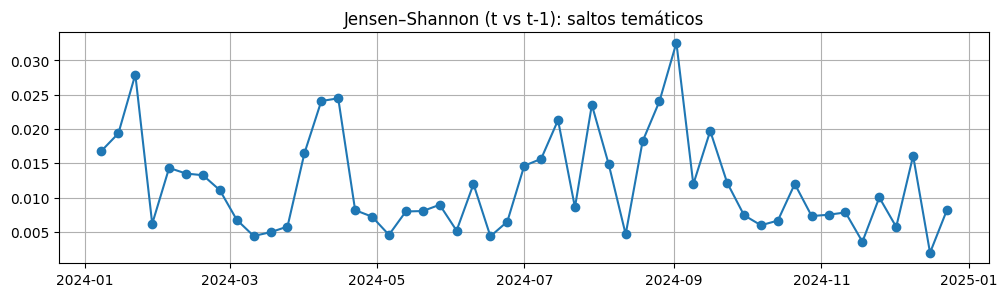

week_start
2024-09-02    0.032581
2024-01-22    0.027956
2024-04-15    0.024488
2024-04-08    0.024093
2024-08-26    0.024073
dtype: float64

In [36]:
# Distribución base anual
eps = 1e-12
p0 = topic_mat.sum(axis=0).astype(float)
p0 = (p0 + eps) / (p0.sum() + eps*len(p0))

P_eps = (P + eps)
P_eps = P_eps / P_eps.sum(axis=1, keepdims=True)

kl = np.sum(rel_entr(P_eps, p0), axis=1)
df_kl = pd.Series(kl, index=df['week_start'])

plt.figure(figsize=(12,3))
plt.plot(df_kl.index, df_kl.values, marker='o')
plt.axvspan(pd.Timestamp('2024-08-01'), pd.Timestamp('2024-09-01'), alpha=0.15)
plt.grid(True)
plt.title("KL Divergence semanal vs distribución anual (sombreado: agosto)")
plt.show()

# Jensen–Shannon entre semanas consecutivas
def js_div(p, q):
    m = 0.5*(p+q)
    return 0.5*np.sum(rel_entr(p, m)) + 0.5*np.sum(rel_entr(q, m))

js = []
idx = df_prop.index
for t in range(1, len(P_eps)):
    js.append(js_div(P_eps[t], P_eps[t-1]))
js = pd.Series(js, index=idx[1:])

plt.figure(figsize=(12,3))
plt.plot(js.index, js.values, marker='o')
plt.grid(True)
plt.title("Jensen–Shannon (t vs t-1): saltos temáticos")
plt.show()

js.sort_values(ascending=False).head(5)

## 15. Conclusiones 


In [37]:
aug_mean = ts[ts.index.month==8].mean()
year_mean = ts.mean()

print("1) Hipótesis (ejemplo): 'En agosto baja significativamente el volumen del BOE'")
print("   - Media agosto:", round(aug_mean,2), "| Media anual:", round(year_mean,2))
print("   - ¿Agosto < Anual?:", aug_mean < year_mean)

print("\n2) Modelos de forecast:")
print("   - Holt-Winters RMSE:", round(rmse_hw,2))
print("   - SARIMAX RMSE:", round(best['rmse'],2), "| order=", best_order, "seasonal=", best_seasonal)

print("\n3) Evidencia temática:")
print("   - Chi-cuadrado Agosto vs resto (p):", f"{p:.3e}")
print("   - Top cambios (residuos est.):")
print(std_res.head(5).to_string())

1) Hipótesis (ejemplo): 'En agosto baja significativamente el volumen del BOE'
   - Media agosto: 381.0 | Media anual: 531.19
   - ¿Agosto < Anual?: True

2) Modelos de forecast:
   - Holt-Winters RMSE: 97.73
   - SARIMAX RMSE: 46.58 | order= (1, 0, 2) seasonal= (0, 0, 0, 0)

3) Evidencia temática:
   - Chi-cuadrado Agosto vs resto (p): 1.342e-21
   - Top cambios (residuos est.):
topico_Energia y Medio Ambiente        8.387860
topico_Cultura y Patrimonio            3.689414
topico_Educacion y Universidades      -3.593362
topico_Empleo Publico y Oposiciones    2.917257
topico_Ciencia e Investigacion        -2.408708
